Import libraries


In [53]:
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns

Open data and clean data

In [2]:
#Create dataframe from CSV
df = pd.read_csv("data/dataset.csv",sep=";")

In [3]:
#See feature with na values.
df.isna().sum()

uuid                                       0
default                                10000
account_amount_added_12_24m                0
account_days_in_dc_12_24m              11836
account_days_in_rem_12_24m             11836
account_days_in_term_12_24m            11836
account_incoming_debt_vs_paid_0_24m    59315
account_status                         54373
account_worst_status_0_3m              54373
account_worst_status_12_24m            66761
account_worst_status_3_6m              57702
account_worst_status_6_12m             60350
age                                        0
avg_payment_span_0_12m                 23836
avg_payment_span_0_3m                  49305
merchant_category                          0
merchant_group                             0
has_paid                                   0
max_paid_inv_0_12m                         0
max_paid_inv_0_24m                         0
name_in_email                              0
num_active_div_by_paid_inv_0_12m       22939
num_active

In [4]:
#Drop feature with more than 40% missing data
df = df.drop(columns=df.columns[(df.isna().sum()>30000)])

In [5]:
#Check if features were dropped
df.shape

(99976, 35)

In [6]:
#Check Y missing values
df.default.isna().sum()

10000

In [7]:
#Missing values in Y is 10% of the data. We will drop these rows
df = df.dropna(subset=['default'])

In [8]:
df.shape

(89976, 35)

In [9]:
#Create X and Y
X = df.drop(columns='default')
y = df.default

Preprocessing

In [10]:
#Create categorical columns variable to preprocessing
cat_cols = ['merchant_category', 'merchant_group', 'name_in_email', 'status_last_archived_0_24m',
            'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
            'status_max_archived_0_12_months', 'status_max_archived_0_24_months']

In [11]:
#Create numerical columns variable to preprocessing
num_cols = ['account_amount_added_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'age', 'avg_payment_span_0_12m',
            'max_paid_inv_0_12m', 'max_paid_inv_0_24m', 'num_active_div_by_paid_inv_0_12m', 'num_active_inv', 'num_arch_dc_0_12m', 'num_arch_dc_12_24m',
            'num_arch_ok_0_12m', 'num_arch_ok_12_24m', 'num_arch_rem_0_12m', 'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m', 'num_unpaid_bills',
            'recovery_debt', 'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m',
            'sum_paid_inv_0_12m', 'time_hours']

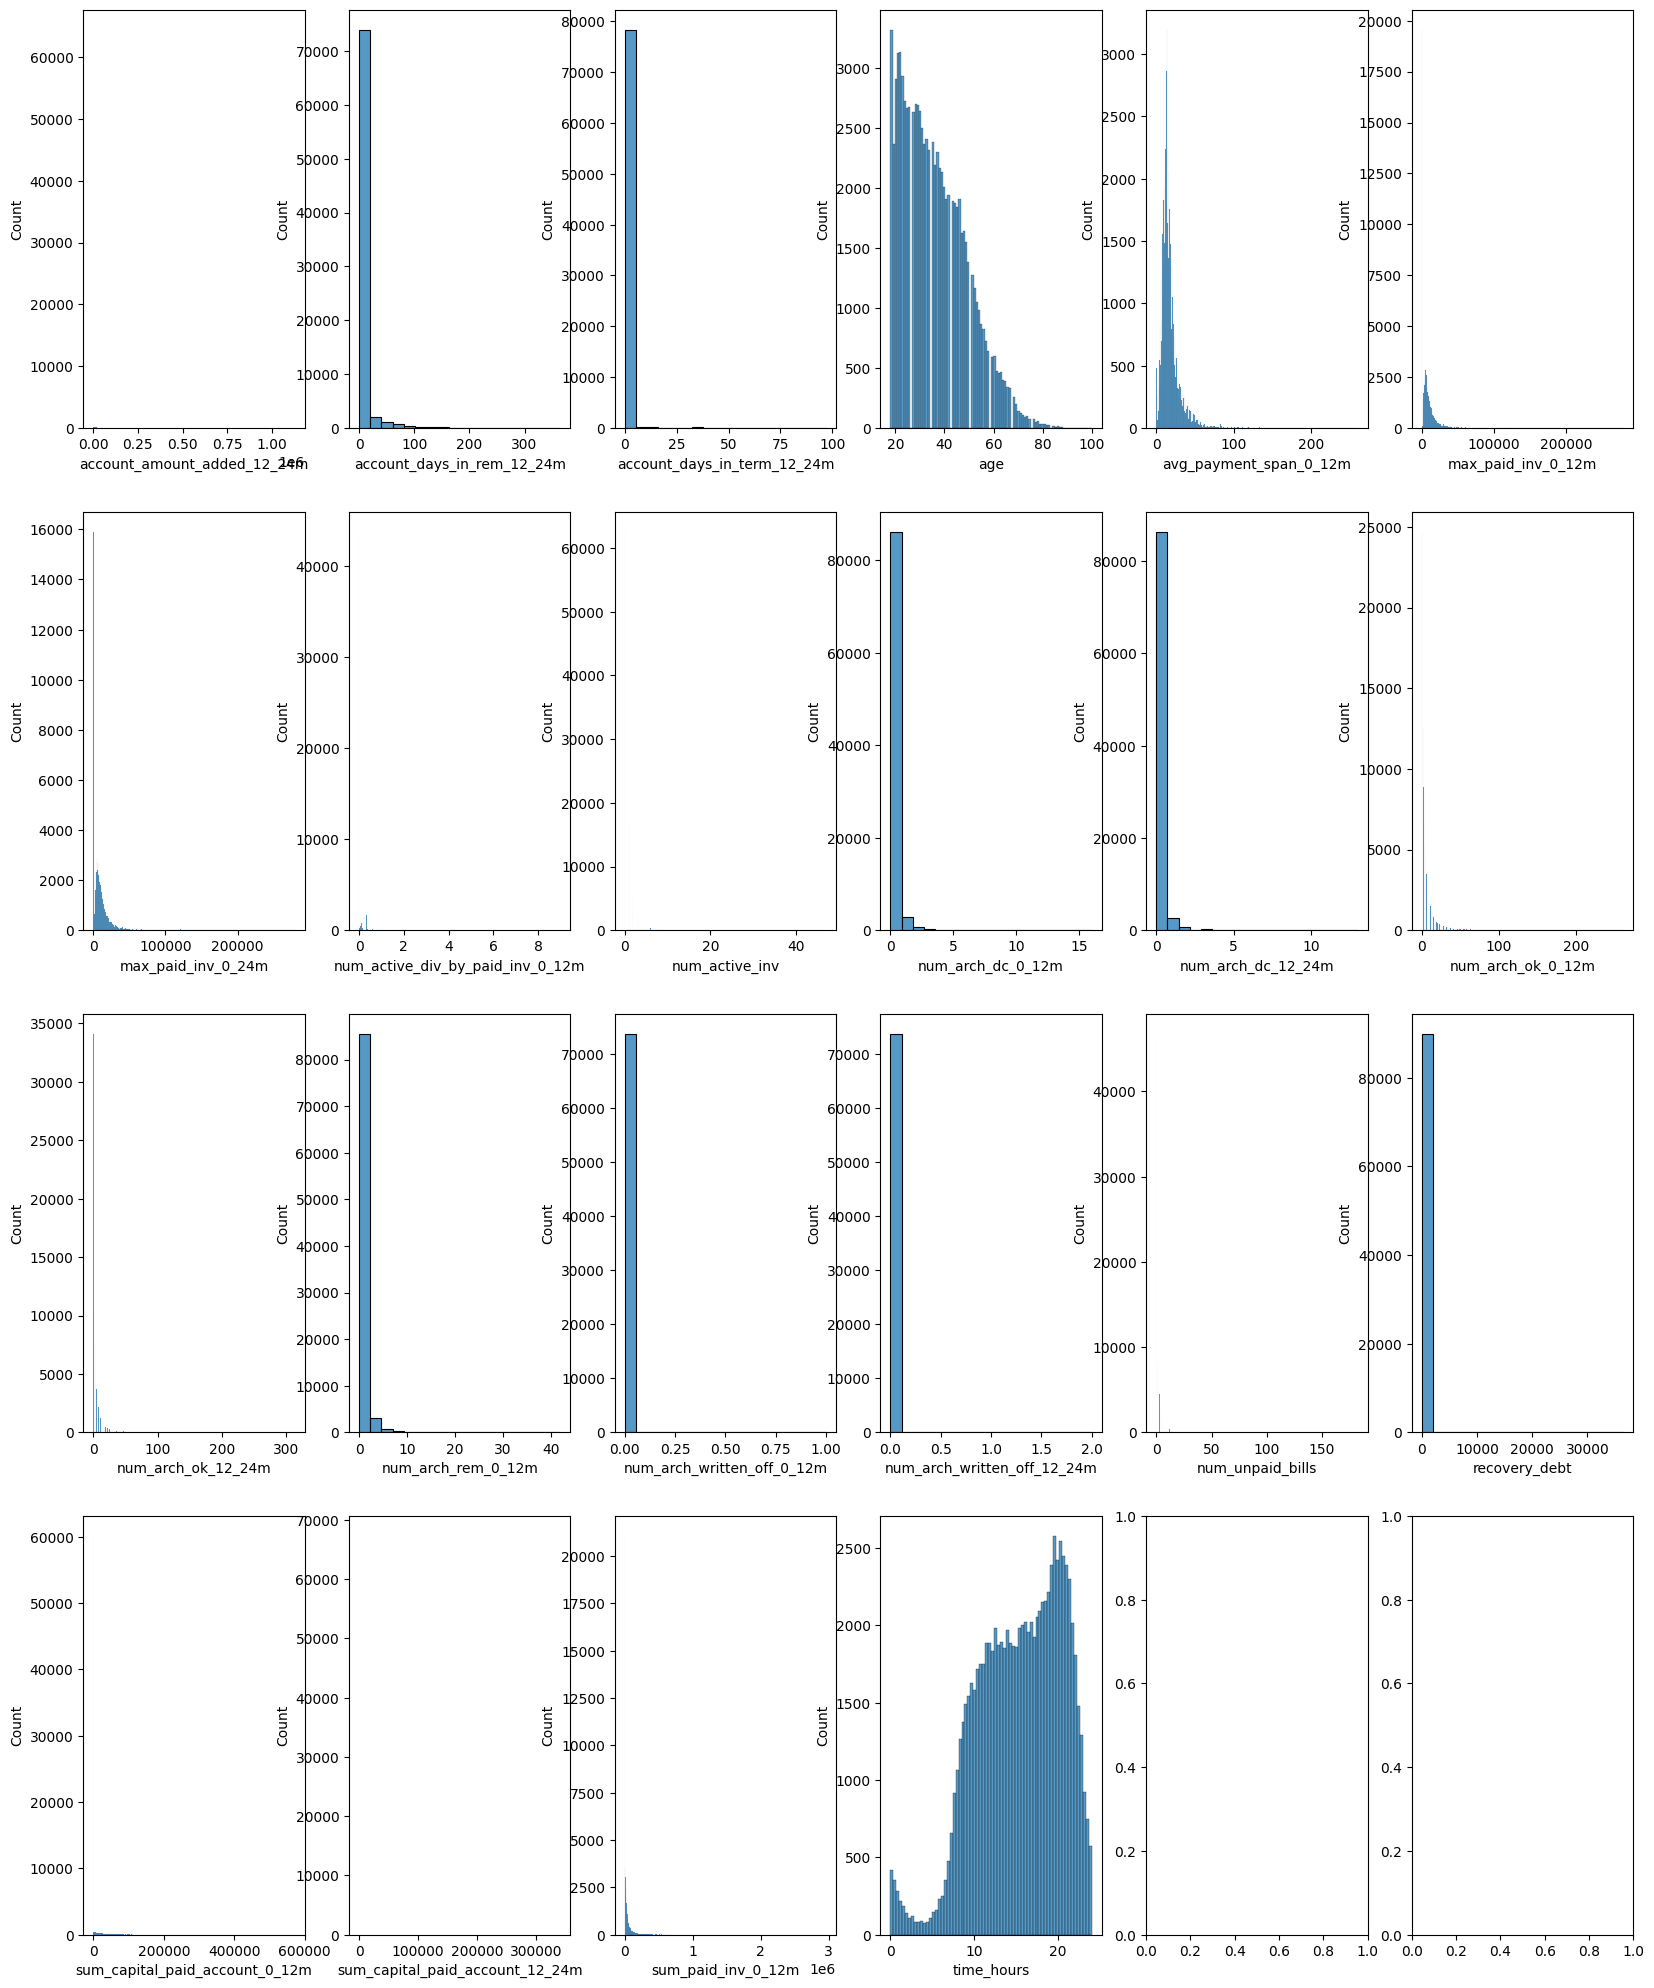

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 25))

for col, ax in zip(num_cols, axes.ravel()):
    sns.histplot(X[col], ax=ax)

In [12]:
#Preprocessing to start = standard data with pipelines.

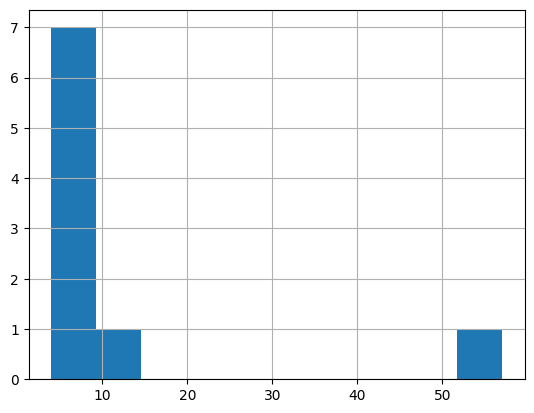

In [30]:
#Check number of categories for categorical features
len(cat_cols)
feat_categorical_nunique = X[cat_cols].nunique()
feat_categorical_nunique.hist();

In [32]:
#Create a new variable with features that have 7 or less categories
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)
len(feat_categorical_small)

6

In [35]:
#OneHotEncoder to categorical features
cat_transformer = make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                OneHotEncoder()
                    )

In [36]:
#RobustScaler to numerical features with no normal distribution
robust_feat = make_pipeline(
                SimpleImputer(strategy='mean'),
                RobustScaler()
                )

In [39]:
#Create the pipeline
preproc = make_column_transformer(
    (cat_transformer, feat_categorical_small),
    (robust_feat, num_cols),
    remainder='drop'
)

In [38]:
preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['status_last_archived_0_24m',
                                  'status_2nd_last_archived_0_24m',
                                  'status_3rd_last_archived_0_24m',
                                  'status_max_archived_0_6_months',
                                  'status_max_archived_0_12_months',
                                  'status_max_archived_0_24_month...
                                  'num_active_div_by_paid_inv_0_12m',
                                  'num_active_inv', 'num_arch_dc_0_12m',
                                  'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
                                  'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
                                  'num_arch_written_off_0_12m',
                                  'num_arch_written_off_12_24m',
                                  'num_unpaid_bills', 'recovery_debt',
                                  'sum_capital_paid_account_0_12m',
                                  'sum_capital_paid_account_12_24m',
                                  'sum_paid_inv_0_12m', 'time_hours'])])

In [41]:
X_preprocessed = preproc.fit_transform(X)

In [43]:
X_preprocessed.shape

(89976, 51)

Model

In [116]:
#Creat a logistic regression model
model = LogisticRegression(
    max_iter=3000,
    penalty='l2'
)

In [117]:
# Add the model to the pipeline
pipe_model = make_pipeline(preproc,
                           model)

In [118]:
#Check the pipeline
pipe_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['status_last_archived_0_24m',
                                                   'status_2nd_last_archived_0_24m',
                                                   'status_3rd_last_archived_0_24m',
                                                   'status_max_archived_0_6_months',
                                                   'status_max_archived_0_12_mo...
                                                   'num_arch_dc_0_12m',
                                                   'num_arch_dc_12_24m',
                                                   'num_arch_ok_0_12m',
                                                   'num_arch_ok_12_24m',
                                                   'num_arch_rem_0_12m',
                                                   'num_arch_written_off_0_12m',
                                                   'num_arch_written_off_12_24m',
                                                   'num_unpaid_bills',
                                                   'recovery_debt',
                                                   'sum_capital_paid_account_0_12m',
                                                   'sum_capital_paid_account_12_24m',
                                                   'sum_paid_inv_0_12m',
                                                   'time_hours'])])),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [120]:
#Cross validate to see how the model performs
cv_model = cross_validate(pipe_model, X, y, scoring='accuracy', cv=5)

In [121]:
#Check the results
cv_model

{'fit_time': array([23.13512754, 25.47443771, 24.65214467, 21.28253436, 17.97002316]),
 'score_time': array([0.039078  , 0.04157567, 0.04300714, 0.03376913, 0.03890109]),
 'test_score': array([0.98571905, 0.98538483, 0.98571826, 0.98516255, 0.98538483])}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [115]:
#Tratar de crear la probabilidad con la pipeline.
cv_model.fit(X_train, y_train)

NameError: name 'predict_proba' is not defined

In [113]:
#Split data before preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [114]:
#Fitting and transforming X_train
X_train_preprocessed = preproc.fit_transform(X_train)

In [107]:
model.fit(X_train_preprocessed,y_train)

/home/pavel/.pyenv/versions/3.10.6/envs/project-test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [91]:
#Fitting and transforming X_train
X_train_preprocessed = preproc.fit_transform(X_train)

In [92]:
#Transform X_test
X_test_preprocessed = preproc.transform(X_test)

In [93]:
model.fit(X_train_preprocessed,y_train)

/home/pavel/.pyenv/versions/3.10.6/envs/project-test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
model.evaluate

In [94]:
prob_model = model.predict_proba(X_test_preprocessed)

In [103]:
prob_default_pay = prob_model[:,1]

In [105]:
prob_default_pay.shape

(17996,)